# Классификация изображений

Для проверки домашнего задания, если не требуется запускать код, рекоомендую использовать мой публичный ноутбук в kaggle: [ссылка на него](https://www.kaggle.com/code/alinaoshroeva/simpsonchiki)

Имя на кэггл - https://www.kaggle.com/alinaoshroeva

# Установка зависимостей

In [ ]:
!pip install -U torch torchvision
import numpy as np
import pandas as pd
import math
import random
import pickle

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from multiprocessing.pool import ThreadPool

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Проверим доступен ли GPU:

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [3]:
!nvidia-smi

Tue Aug 29 10:13:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Нам необходима версия pillow  5.3.0 удалим старую версию и установим новую. Здесь должна быть версия 5.3.0. если это не так перезагрузите ноутбук

In [4]:
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
import PIL
print(PIL.__version__)

9.4.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
#разархивируем
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d journey-springfield

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
#количество эпох
EPOCHES = 3

Ниже мы исспользуем враппер над датасетом для удобной работы.

ToTensor конвертирует PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1], затем производится масштабирование:  $input = \frac{input - \mu}{\text{standard deviation}} $

Константы - средние и дисперсии по каналам на основе ImageNet

Переопределяем метод getitem для удобства работы.

Используем LabelEncoder для преобразования строковых меток классов в id и обратно.

Картинки разного размера, так как брались напрямую с видео, поэтому приводим их к одному размеру (метод _prepare_sample)

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Path - это объект из библиотеки pathlib, который представляет путь к файлу или директории в операционной системе.

TRAIN_DIR и TEST_DIR это переменные которые содержат пути к директориям с данными обучения и тестирования. train_val_files список файлов обучающего набора данных с расширением .jpg в алфавитном порядке. test_files аналогично для тестового набора.

In [10]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Создаем список лейблов

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]

Разобьём выборку на тестовую и валидационную

In [12]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow

# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#    for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Посмотрим героев внутри датасета.

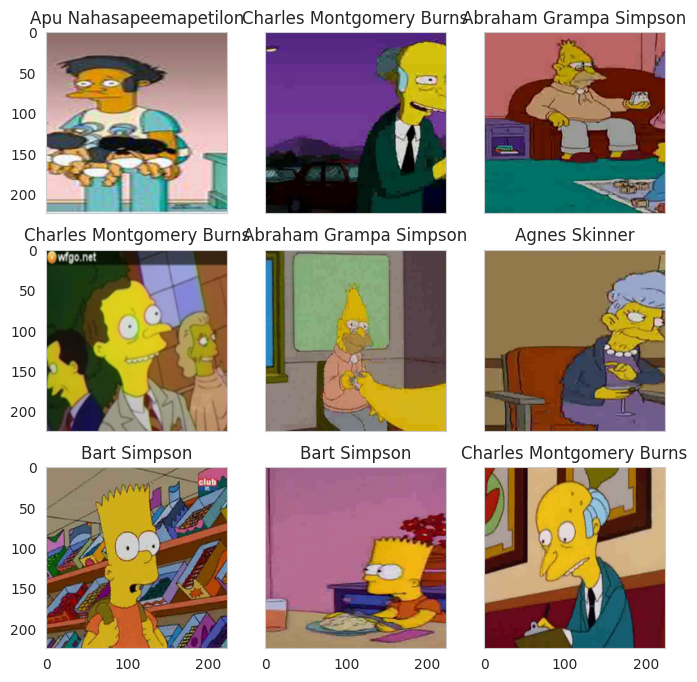

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Draft version

Простая свёрточная нейросеть

Описание слоёв:

1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [15]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
model = simple_cnn
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

## Обучение

Запустим обучение сети.

In [21]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [22]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=500)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 3.152973636866178


epoch:  33%|███▎      | 1/3 [02:33<05:06, 153.19s/it]


Epoch 001 train_loss: 3.1530     val_loss 2.8968 train_acc 0.1144 val_acc 0.1731
loss 2.623686214443741


epoch:  67%|██████▋   | 2/3 [05:07<02:33, 153.61s/it]


Epoch 002 train_loss: 2.6237     val_loss 2.4544 train_acc 0.2731 val_acc 0.3131
loss 2.3167766321767735


epoch: 100%|██████████| 3/3 [07:19<00:00, 146.67s/it]


Epoch 003 train_loss: 2.3168     val_loss 2.1827 train_acc 0.3649 val_acc 0.4085


Построим кривые обучения

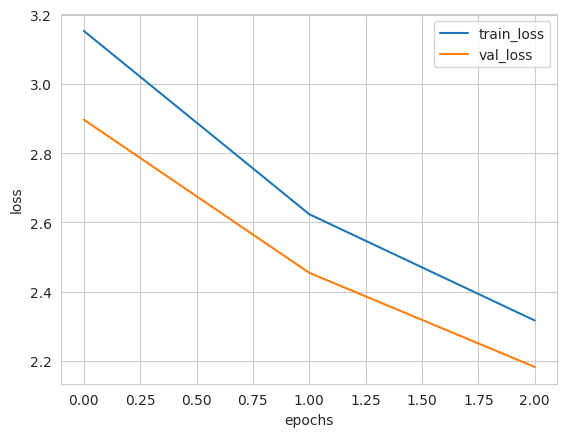

In [27]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

Переведем сеть в режим предсказания и получить вектор вероятностей  того, что объект относится к тому или иному классу.

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score

Метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [32]:
f1_score(actual_labels, y_pred, average="micro")

0.3

**F1** = 0.3

## Submit #1

In [33]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [34]:
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [35]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

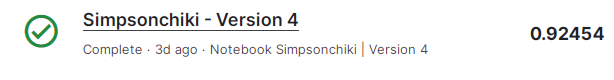

# EfficientNet

## Архитектура

> EfficientNet-B0, была разработана авторами, искавшими архитектуру сети, оптимизирующую как точность, так и требуемое количество вычислений. Основной строительный блок EfficientNet-B0 – это MBConv (мобильная обращенная свертка с узким местом), к которой добавлено сжатие-и-стимуляция.
>
>В традиционном ResBlock'е количество каналов следует образцу широкое-узкое-широкое (также называемое "узким местом"), параллельно с обходной связью идентичности. Вход имеет большое количество каналов, сжимаемых сверткой 1х1. Затем количество опять увеличивается сверткой 1х1, чтобы можно было прибавить данные по связи идентичности.
>
>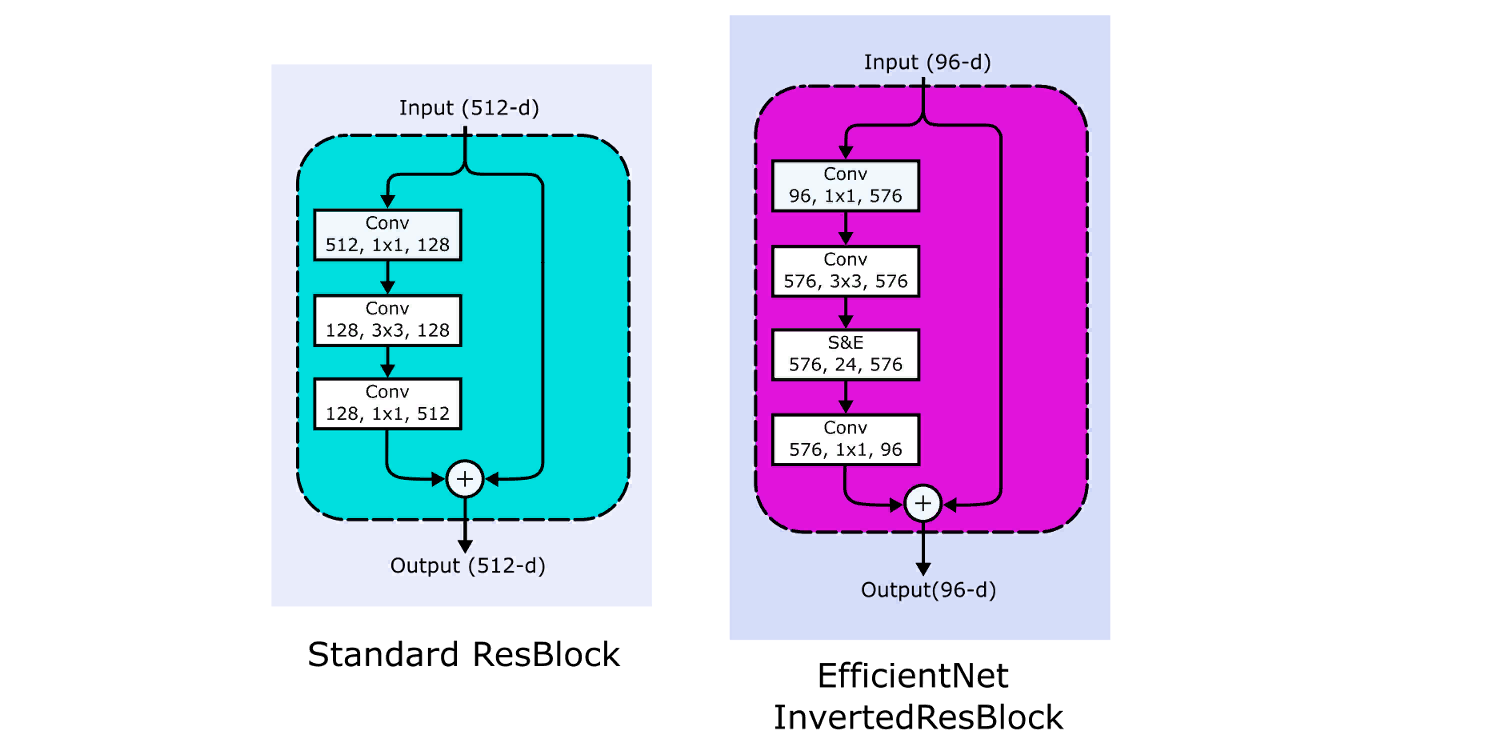
>
> Инвертированный остаточный блок (Inverted Residual Block), как и предполагает его название, использует подход узкий/широкий/узкий. Плоский вход расширяется сверткой 1*1 перед применением глубинной свертки 3*3, сильно сокращающей количество параметров. Затем снова используется свертка 1*1 для сокращения количества каналов, чтобы можно было прибавить данные по связи идентичности.
>
>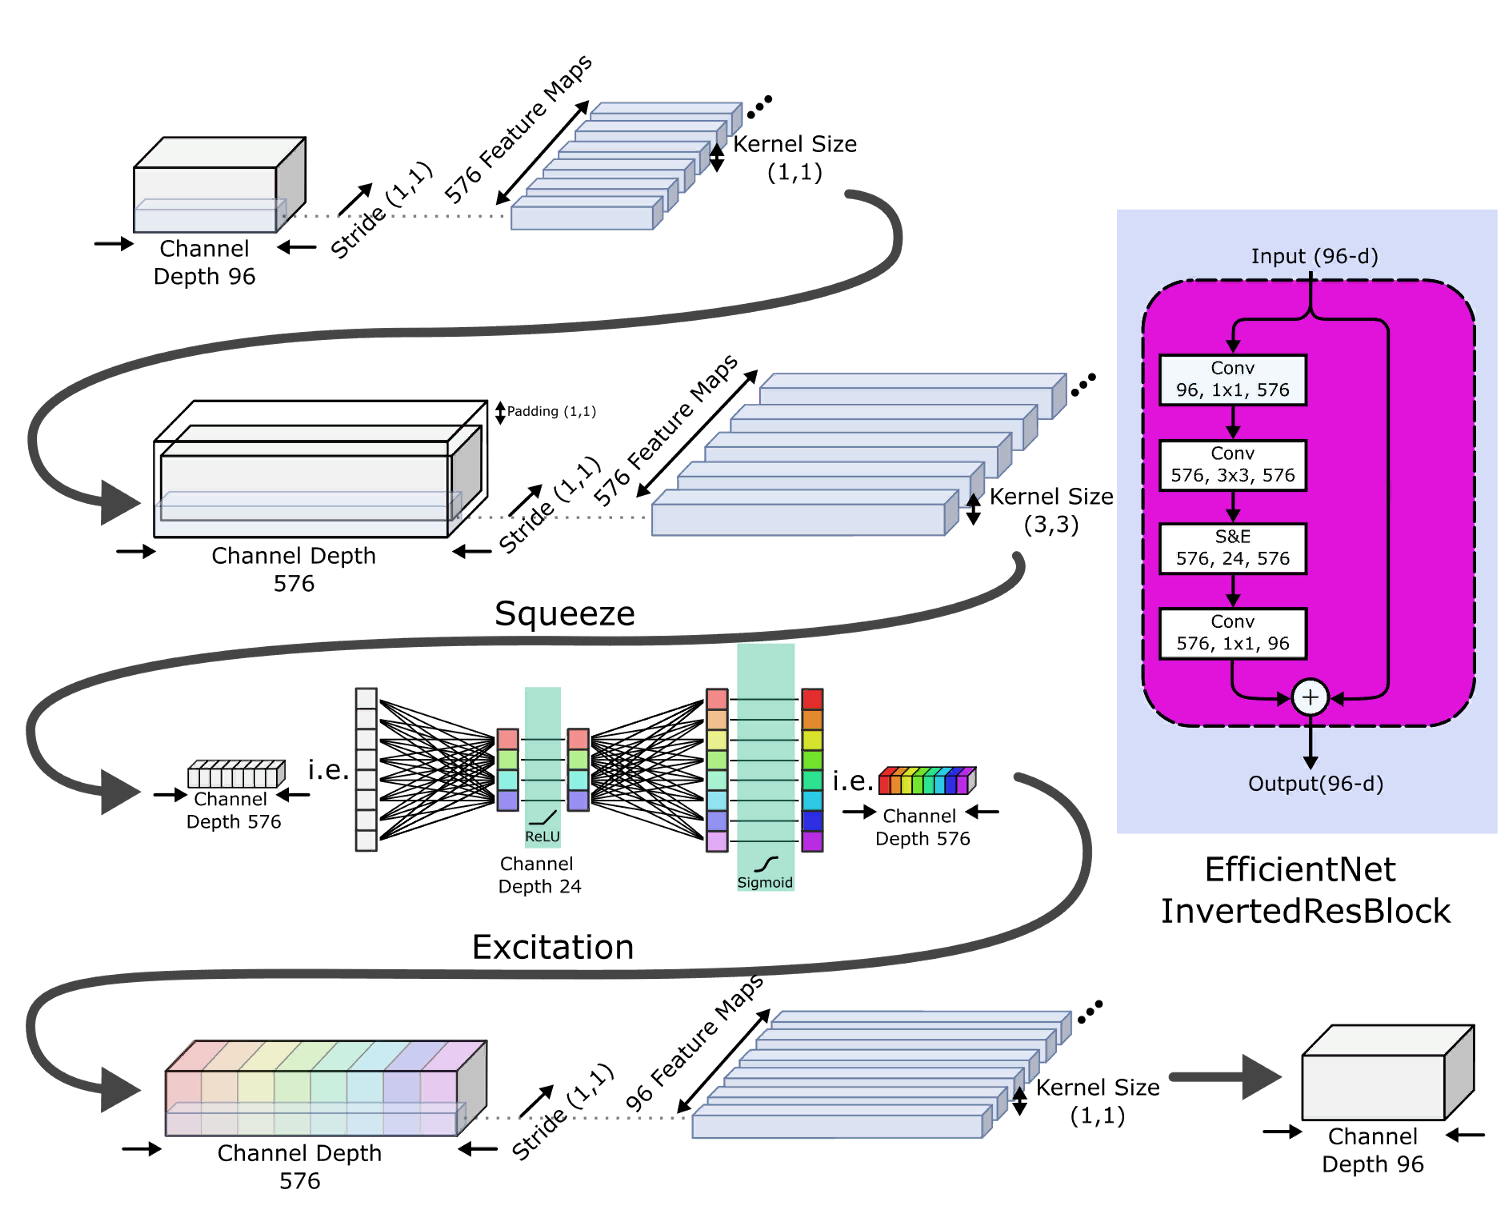
>
>Эта структура уменьшает общее количество операций и размер модели, что позволяет EfficientNet-B0 иметь точность Топ-5, сравнимую с точностью ResNet-34, несмотря на то, что у нее вчетверо меньше тренируемых параметров, и ее обучение требует на порядок меньше вычислительных операций.

Взято [отсюда](https://proglib.io/p/issleduem-arhitektury-svertochnyh-neyronnyh-setey-s-pomoshchyu-fast-ai-2020-12-28)


Но ниже используем EfficientNet-B2

In [36]:
torch.cuda.empty_cache()

In [ ]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)

efficientnet_b2.to(DEVICE)
model = efficientnet_b2

## Обучение

Запустим обучение сети.

In [38]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=32)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.5756212626976893


epoch:  33%|███▎      | 1/3 [04:16<08:32, 256.23s/it]


Epoch 001 train_loss: 0.5756     val_loss 0.2182 train_acc 0.8637 val_acc 0.9461
loss 0.5073821236505744


epoch:  67%|██████▋   | 2/3 [08:18<04:08, 248.19s/it]


Epoch 002 train_loss: 0.5074     val_loss 0.2661 train_acc 0.8716 val_acc 0.9295
loss 0.21493681301248022


epoch: 100%|██████████| 3/3 [12:21<00:00, 247.21s/it]


Epoch 003 train_loss: 0.2149     val_loss 0.3129 train_acc 0.9441 val_acc 0.9232


Построим кривые обучения

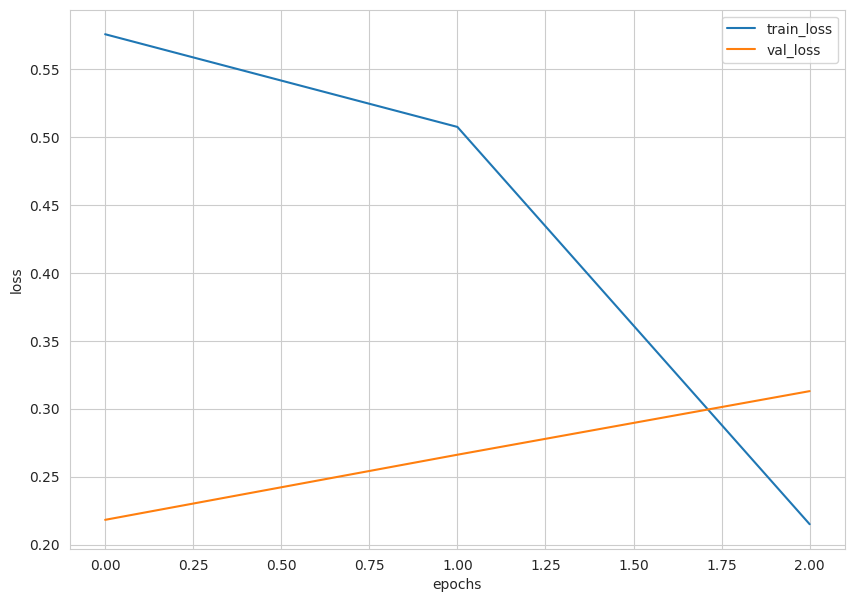

In [39]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

In [40]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score

In [41]:
f1_score(actual_labels, y_pred, average="micro")

1.0

**F1** = 1.0

## Submit #2

In [42]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.to_csv('gdrive/My Drive/simpsons/efficientnet_submission.csv', index=False)

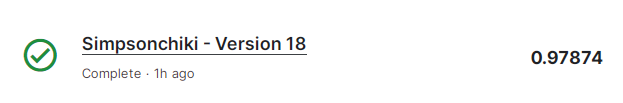

# Аугументация


In [43]:
torch.cuda.empty_cache()

Посмотрим для кого у нас меньше всего данных

In [ ]:
counts = pd.Series(train_val_labels).value_counts()

<BarContainer object of 42 artists>

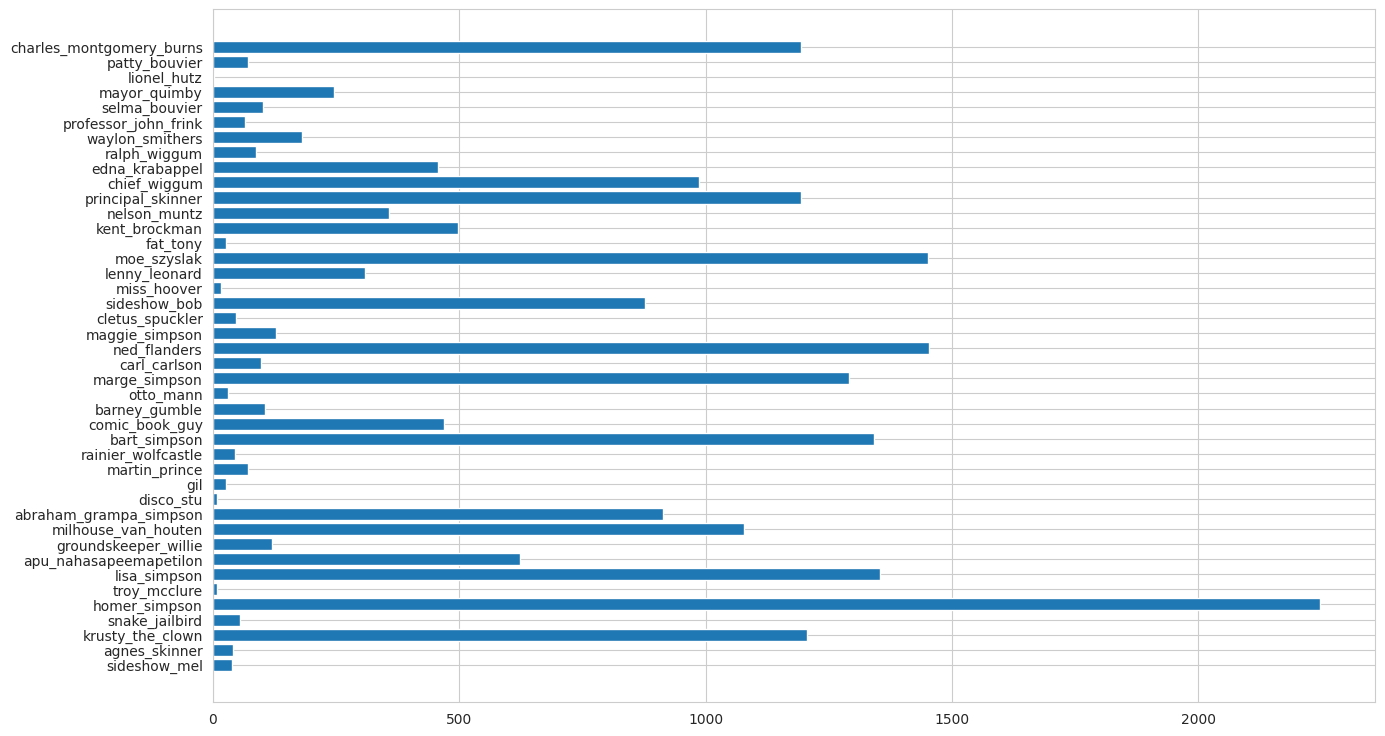

In [45]:
labels = list(set(train_val_labels))
plt.figure(figsize=(15, 9))
plt.barh(labels, counts[labels])

Видим, что классы сильно несбалансированы. Будем использовать аугументацию, но для некоторых персонажей крайне мало картинок, их лучше добавить вручную

Скопируем данные в выходную директорию, чтобы мы могли сохранять картинки

In [46]:
data = counts.to_frame('count')

#сколько нужно добавить каждому классу, чтобы было 1500 картинок
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

#сколько нужно добавить за одну итерацию
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)

data

,count,to_add,one_iteration
homer_simpson,2246,0,0
ned_flanders,1454,46,1
moe_szyslak,1452,48,1
lisa_simpson,1354,146,1
bart_simpson,1342,158,1
marge_simpson,1291,209,1
krusty_the_clown,1206,294,1
principal_skinner,1194,306,1
charles_montgomery_burns,1193,307,1
milhouse_van_houten,1079,421,1


Будем использовать три типа преобразования:
* RandomCrop
* RandomRotation
* RandomHorizontalFlip

In [47]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [48]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

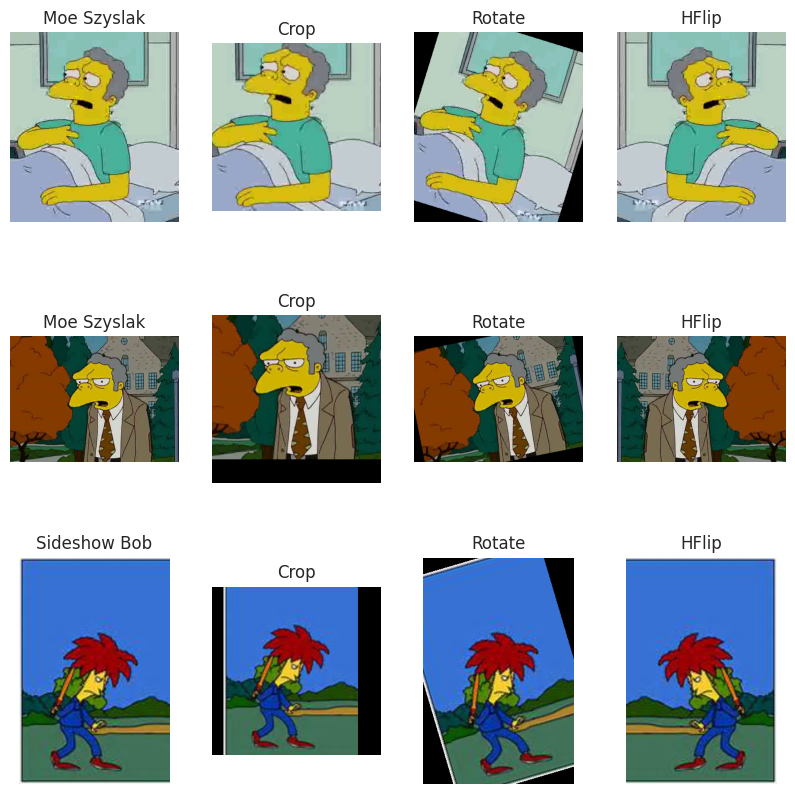

In [49]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')

    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [50]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size

    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [03:46<00:00, 92.24it/s]


In [ ]:
#!zip -r "journey-springfield-augmented.zip" . > /dev/null

## Результаты аугументации

Посмотрим, как теперь распределены данные

<BarContainer object of 42 artists>

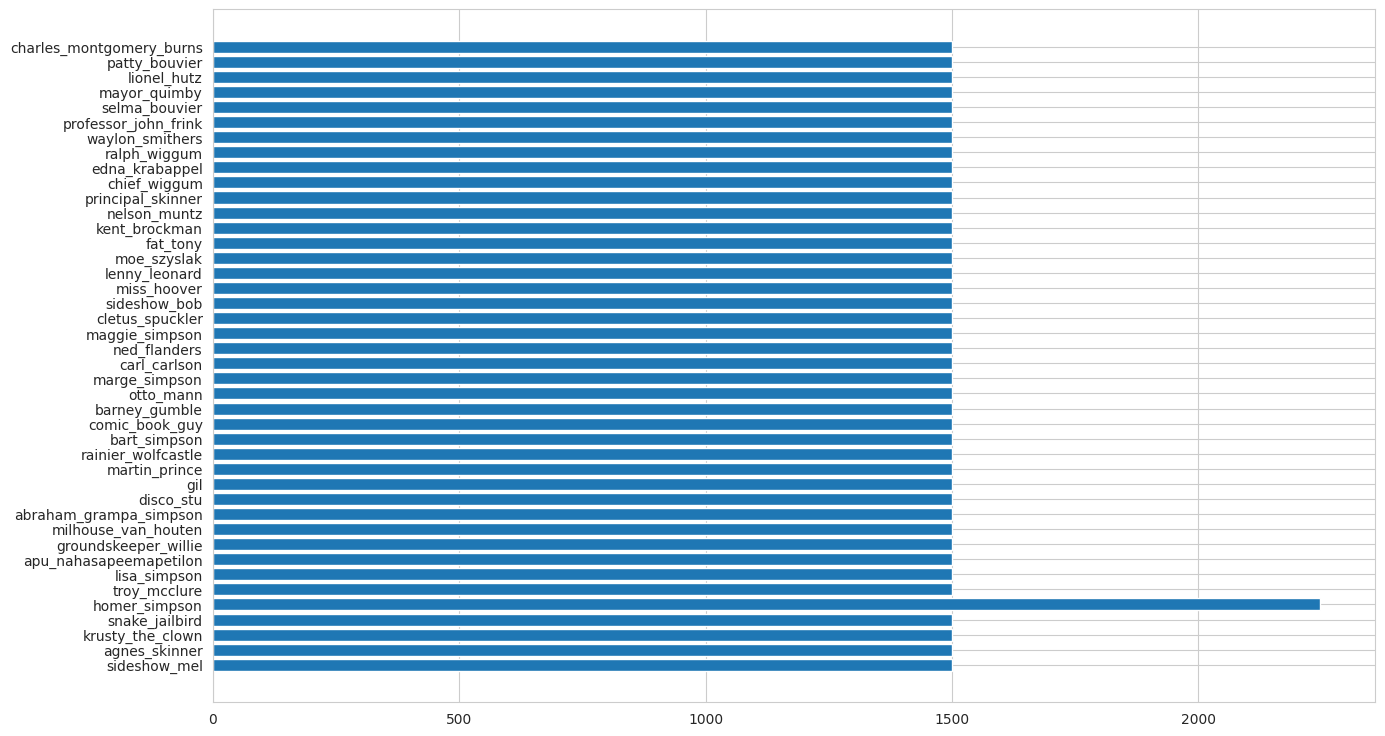

In [51]:
aug_files = list(TRAIN_DIR.rglob('*.jpg'))
aug_labels = [path.parent.name for path in aug_files]
aug_counts = pd.Series(aug_labels).value_counts()

plt.figure(figsize=(15, 9))
plt.barh(labels, aug_counts[labels])

## Обучение
Разобьём выборку на тестовую и валидационную

In [52]:
train_files, val_files = train_test_split(aug_files, test_size=0.25, \
                                          stratify=aug_labels)

In [53]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [54]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=32)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.27285061572066227


epoch:  33%|███▎      | 1/3 [05:28<10:56, 328.21s/it]


Epoch 001 train_loss: 0.2729     val_loss 1.1284 train_acc 0.9331 val_acc 0.7126
loss 0.21688976343413854


epoch:  67%|██████▋   | 2/3 [10:52<05:25, 325.41s/it]


Epoch 002 train_loss: 0.2169     val_loss 1.0854 train_acc 0.9469 val_acc 0.7323
loss 0.29500366334533895


epoch: 100%|██████████| 3/3 [16:16<00:00, 325.38s/it]


Epoch 003 train_loss: 0.2950     val_loss 0.8996 train_acc 0.9274 val_acc 0.7955


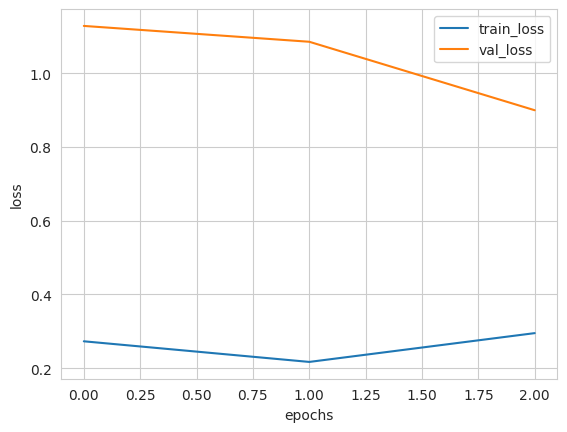

In [55]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

In [56]:
def predict_one_sample(model, inputs, device=DEVICE):
   """Предсказание, для одной картинки"""
   with torch.no_grad():
       inputs = inputs.to(device)
       model.eval()
       logit = model(inputs).cpu()
       probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
   return probs

ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score

In [57]:
f1_score(actual_labels, y_pred, average="micro")

0.785

**F-1** =  0.855

## Submit #3

In [58]:
DEVICE = torch.device("cuda")
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('gdrive/My Drive/simpsons/aug_submission.csv', index=False)

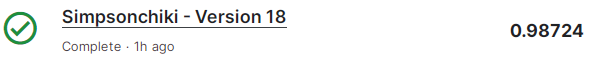

# Визуализация уверенности сети

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

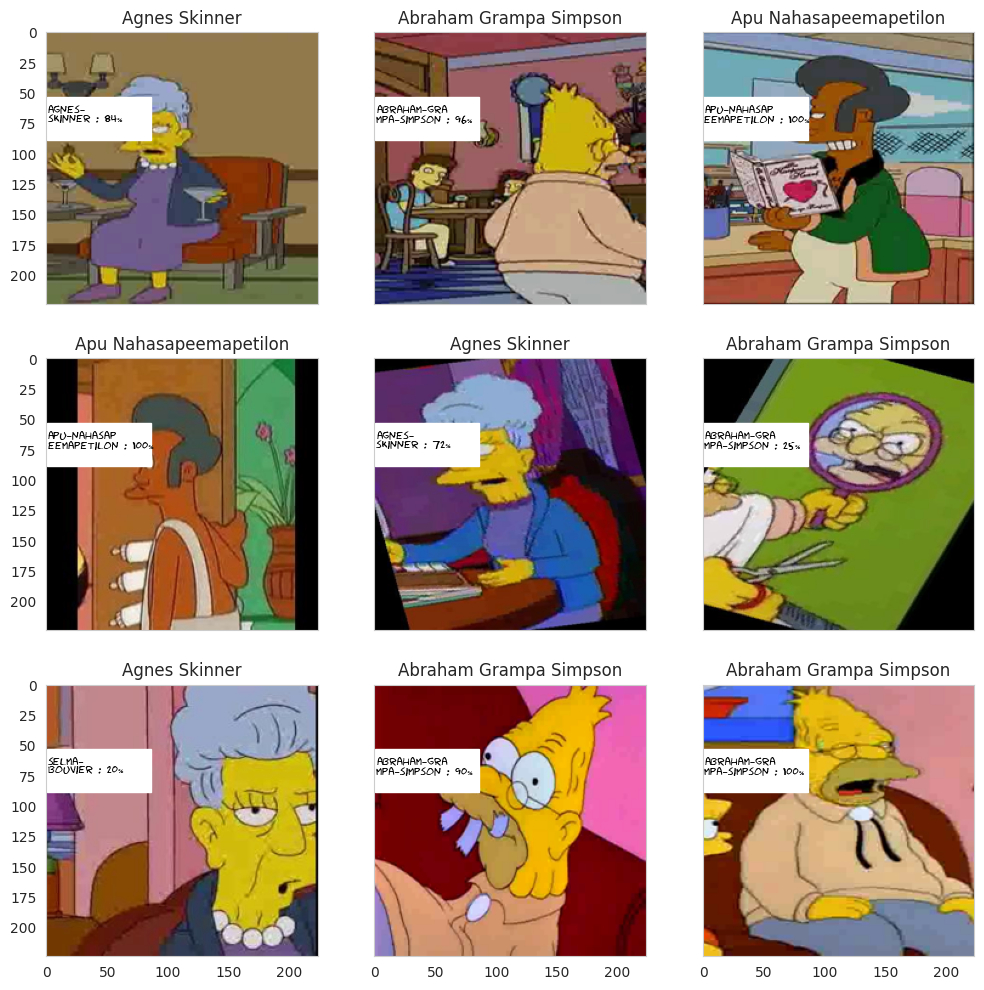

In [59]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Заключение

Лучший результат по F-1 метрике получился 0,987 при использовании EfficientNet и аугументации. Для повышения этого результата можно добавить картинок тех персонажей, которых в обучающей выборке до аугументации было очень мало, например, для lionel_hutz их всего 3.